# Navigation

---
### DRL Project 1

Qian Sun

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.16 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. My Implementation and Comparison Between Models (more details in report)

Recall that we have modified our *Agent* class for it to be able to do ddqn update too. In addition, we implemented a DuelingQNetwork class, here we first import them into our environment.

In [5]:
from dqn_agent import Agent
from model import QNetwork, DuelingQNetwork

Then we import some necessary dependencies

In [6]:
from collections import deque
import matplotlib.pyplot as plt
import random, torch
%matplotlib inline

plt.ion()

In [7]:
# Let's recycle the training function from lessons first
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, cache_name='dqn'):
    """
    Deep Q-learning
    
    Params
    ======
        n_episodes (int): number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy policy 
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) to decrease epsilon
        cache_name (str): name of the saved model
    """
    
    scores = []                                               # list containing scores from each episode                 
    scores_window = deque(maxlen=100)                         # store only the last 100 scores
    eps = eps_start                                           # initialize epsilon (for epsilon-greedy policy)
    
    for i_episode in range(1, n_episodes + 1):                # run n_episodes
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        state = env_info.vector_observations[0]               # get the initial state
        score = 0                                             # initialize the score
        
        for t in range(max_t):                                # run for maximum of max_t timesteps 
            action = agent.act(state, eps)                    # select the action
            env_info = env.step(action)[brain_name] 
            next_state = env_info.vector_observations[0]      # get the state
            reward = env_info.rewards[0]                      # get the reward
            done = env_info.local_done[0]                     # whether the episode is complete or not
            
            agent.step(state, action, reward, next_state, done)  # train the agent 
            score += reward                                      # update the score
            
            state = next_state                                   # update the state
            if done:                                             # break if episode is complete
                break
        
        scores_window.append(score)                # update the window of scores
        scores.append(score)                       # update the list of scores
        eps = max(eps_end, eps * eps_decay)        # modify epsilon
        average_score = np.mean(scores_window)
        print('\rEpisode {} \tAverage score: {: .2f}'.format(i_episode, average_score), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {} \tAverage score: {: .2f}'.format(i_episode, average_score))
            
        if average_score >= 13:      # check if environment is solved
            print('\nEnvironment solved in {: d} episodes!\tAverage Score: {: .2f}'.format(i_episode - 100, average_score))
            torch.save(agent.qnetwork_local.state_dict(), cache_name+'.pth')
            break
    
    return scores

Here we follow the hyperparameters used in the lessons, specifically:

| Hyperparameter  | Value |
| --------------- | ----- |
| n_episodes      | 5000  |
| max_t           | 2000  |
| eps_start       | 1.0   |
| eps_end         | 0.1   |
| eps_decay       | 0.995 |

#### Vanilla DQN
Recall that the default weights-updating method is 'dqn'.

In [8]:
agent = Agent(nnstructure=QNetwork, state_size=state_size, action_size=action_size, seed=72)
scores = dqn()

Episode 100 	Average score:  1.09
Episode 200 	Average score:  4.10
Episode 300 	Average score:  6.56
Episode 400 	Average score:  9.93
Episode 500 	Average score:  11.74
Episode 557 	Average score:  13.01
Environment solved in  457 episodes!	Average Score:  13.01


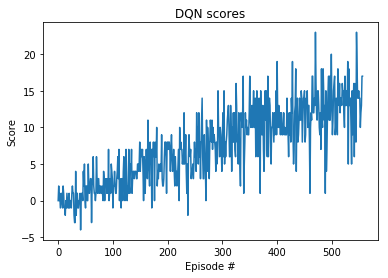

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('results/dqn_scores.png', bbox_inches='tight')
plt.title('DQN scores')
plt.show()

#### DDQN

In [10]:
agent = Agent(nnstructure=QNetwork, state_size=state_size, action_size=action_size, seed=72, update_method='ddqn')
scores = dqn(cache_name='ddqn')

Episode 100 	Average score:  0.92
Episode 200 	Average score:  5.15
Episode 300 	Average score:  7.38
Episode 400 	Average score:  10.17
Episode 499 	Average score:  13.02
Environment solved in  399 episodes!	Average Score:  13.02


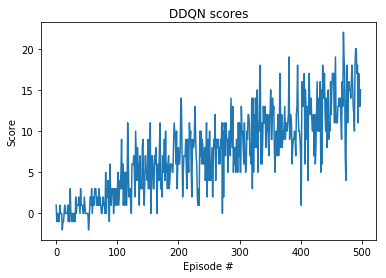

In [11]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('results/ddqn_scores.png', bbox_inches='tight')
plt.title('DDQN scores')
plt.show()

#### Dueling DQN

In [12]:
agent = Agent(nnstructure=DuelingQNetwork, state_size=state_size, action_size=action_size, seed=72, update_method='ddqn')
scores = dqn(cache_name='duelingdqn')

Episode 100 	Average score:  0.85
Episode 200 	Average score:  3.06
Episode 300 	Average score:  5.66
Episode 400 	Average score:  10.59
Episode 493 	Average score:  13.07
Environment solved in  393 episodes!	Average Score:  13.07


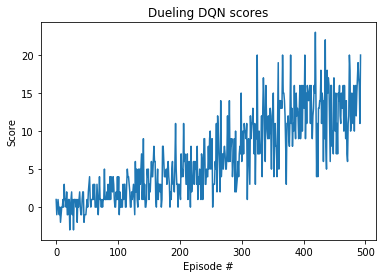

In [13]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('results/duelingdqn_scores.png', bbox_inches='tight')
plt.title('Dueling DQN scores')
plt.show()